Phần mềm mang giấy phép GNU General Public Licence. (c) Nguyễn Ngọc Sáng, Zhukovsky 12/2018.

[@SangVn](https://github.com/SangVn) [@VnCFD](https://vncfdgroup.wordpress.com/)

*vncfd_1D*

# Thư viện vncfd_1D

Thư viện vncfd_1D hỗ trợ tính toán động lực học một chiều dòng chảy không nhớt, cụ thể là giải hệ phương trình Euler 1D.
Thư viện sử dụng ba sơ đồ: `Godunov + Runge-Kutta 1 (Euler), MUSCL + Runge-Kutta 2, WENO5 + Runge-Kutta 3`.

### Phương trình Euler 1D 

Dòng chảy lưu chất không nhớt được mô tả bởi hệ phương trình Euler. Hệ phương trình đối với dòng chảy một chiều có dạng:
$$\frac{\partial U}{\partial t} + \frac{\partial F}{\partial x} = 0 \qquad(1)$$
trong đó:
\begin{align}
U & = \begin{pmatrix} \rho \\ \rho u \\ \rho e\end{pmatrix}, & 
F & = \begin{pmatrix} \rho u \\ \rho u^2 + p \\ \rho ue + pu\end{pmatrix}.
\end{align}

với $\rho$ - khối lượng riêng, $u$ - vận tốc theo phương x, $p$ - áp suất, $e$ - năng lượng một đơn vị khối lượng lưu chất. Năng lượng $e$ gồm hai thành phần: nội năng $\varepsilon$ và động năng $u^2/2$: $$e = \varepsilon + \frac{u^2}{2}$$ Ta thấy có ba phương trình nhưng có tới 4 ẩn. Để 'khép kín' hệ ta sử dụng thêm phương trình trạng thái:
$$p=p(\rho, \varepsilon)$$ 
Đối với khí lý tưởng: $$p = (\gamma-1)\rho\varepsilon \qquad (2)$$
với $\gamma$ là số mũ đoạn nhiệt. Trường hợp khí là không khí (xem như khí hai nguyên tử) thì $\gamma=1.4$.

### Bài toán Riemann

Bài toàn Riemann trong động lực học lưu chất: 
$$U_t + F(U)_x = 0 \qquad (4)\\
U(t=0)= 
\begin{cases}
U_L(\rho_L, u_L, p_L); \quad x<x^* \\ 
U_R(\rho_R, u_R, p_R); \quad x>x^*
\end{cases}
$$
Một số bài toán cụ thể:
<img src='riemann_problem.png'>

# Sử dụng thư viện vncfd_1D

Thư viện vncfd_1D gồm có 5 module:
- constants: chứa các hằng số ví dụ như số mũ đoạn nhiệt $\gamma=1.4$
- convert_variable: chứa các hàm chuyển đổi các kiểu biến ví dụ như từ biến gốc $P(\rho, u, p)$ sang biến bảo toàn $U(\rho, \rho u, \rho e)$
- decay: giải quyết bài toán phân rã gián đoạn
- muscl: sơ đồ muscl và godunov
- weno5: sơ đồ weno5
- runge-kutta: phương pháp runge-kutta 

### Sử dụng thư viện:

Bước 1. Chia lưới

Bước 2. Thiết lập điều kiện ban đầu 

In [1]:
# import thư viện 
from lib.euler_solver import*

#chia lưới
xl = 0    #giới hạn biên trái
xr = 1    #giới hạn biên phải
nx = 81   #số điểm lưới 
x, dx = np.linspace(xl, xr, nx, retstep=True)  #chia lưới

#điều kiện ban đầu 
Pl = [1.0, 0.0, 1000.0]
Pr = [1.0, 0.0, 0.01]
xstar = 0.5
t_max = 0.01

#tạo mảng chứa nghiệm 
Ps = np.zeros((nx, 3))
Ps[:int(xstar/dx)] = Pl
Ps[int(xstar/dx):] = Pr

Bước 3. Tìm nghiệm

- nếu là bài toán Riemann thì có thể tìm nghiệm chính xác bằng hàm: riemann_exact_solution()
- chọn phương pháp tái cấu trúc nghiệm:
    godunov_reconstr, muscl_reconstr, weno5_reconstr
- nếu chọn musl_reconstr thì có thể thay đổi giới hạn độ dốc limiter trong file `muscl.py`:
    - mặc định limiter = minmod
    - các hàm khác: koren, superbee, ospre, vanleer77, vanleer74
- gọi hàm tìm nghiệm: euler_solver()    

In [2]:
%time P_exact = riemann_exact_solution(Pl, Pr, x, xstar, t_max)

CPU times: user 331 µs, sys: 58 µs, total: 389 µs
Wall time: 295 µs


In [3]:
%time P_godunov = euler_solver(Ps.copy(), godunov_reconstr, x, t_max, CFL=0.45)

CPU times: user 142 ms, sys: 218 µs, total: 142 ms
Wall time: 139 ms


In [4]:
%time P_muscl = euler_solver(Ps.copy(), muscl_reconstr, x, t_max, CFL=0.45)

CPU times: user 413 ms, sys: 3.27 ms, total: 416 ms
Wall time: 415 ms


In [5]:
%time P_weno5 = euler_solver(Ps.copy(), weno5_reconstr, x, t_max, CFL=0.45)

CPU times: user 3.41 s, sys: 31.6 ms, total: 3.44 s
Wall time: 3.43 s


Bước 4. Vẽ đồ thị và so sánh kết quả

- Sử dụng hàm plot_4P() để so sánh 4 kết quả tìm được và lưu ảnh

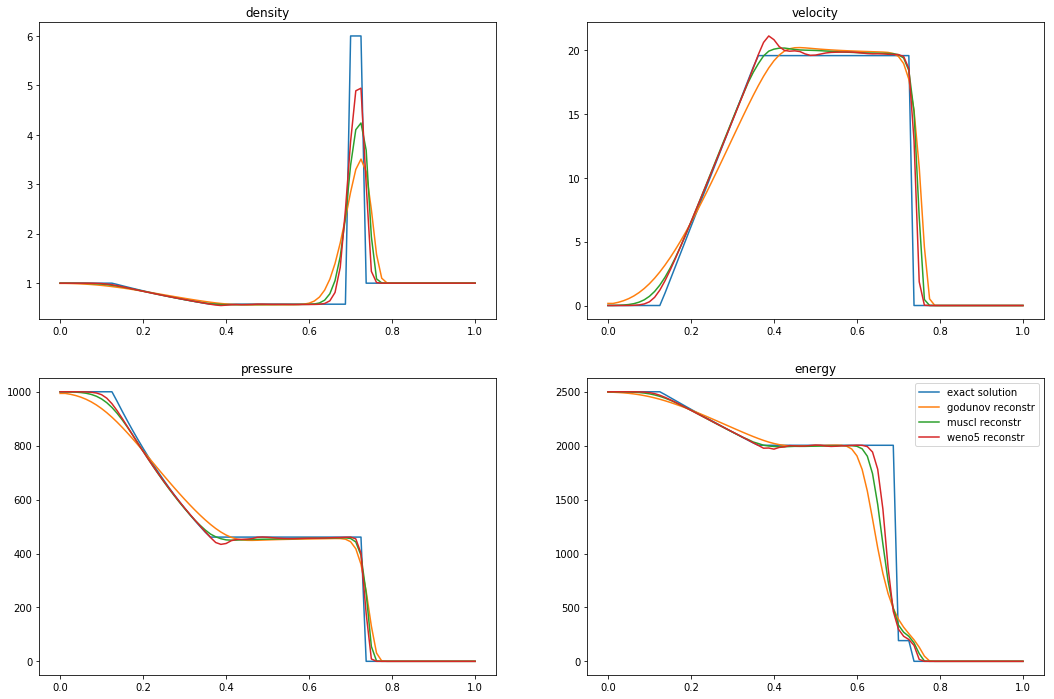

CPU times: user 545 ms, sys: 12.1 ms, total: 557 ms
Wall time: 565 ms


In [6]:
%time plot_4P(x, P_exact, P_godunov, P_muscl, P_weno5, 'riemann')

# Các bài toán khác 
Trường hợp không phải là bài toán Riemann, ví dụ bài toán Shu-Osher:

$$(\rho, u, p)_l = (3.857143, 2.629369, 10.3333)\\
(\rho, u, p)_r = (1+0.2sin(5x-25), 0.0, 1.0)\\
x_{star} = 1.0; \ t_{max} = 1.8
$$

sử dụng thư viện như sau:

In [18]:
#shu-osher problem
Pl = [3.857143, 2.629369, 10.3333]
Pr = [1.2, 0.0, 1.0]
xstar = 1
t_max = 1.8

#sử dụng các lưới khác nhau:
#lưới mịn 
nx_f = 1001
x_fine, dx_f = np.linspace(0, 10, nx_f, retstep=True)

#điều kiện ban đầu 
Ps_fine = np.zeros((nx_f, 3))
istar = int(xstar/dx_f)
Ps_fine[:istar] = Pl
Ps_fine[istar:] = Pr

for i in range(istar, nx_f): Ps_fine[i][0] = 1 + 0.2*np.sin(5*x_fine[i] - 25)

#lưới thô 
nx_c = 401
x_coarse, dx_c = np.linspace(0, 10, nx_c, retstep=True)

#điều kiện ban đầu 
Ps_coarse = np.zeros((nx_c, 3))
istar = int(xstar/dx_c)
Ps_coarse[:istar] = Pl
Ps_coarse[istar:] = Pr

for i in range(istar, nx_c): Ps_coarse[i][0] = 1 + 0.2*np.sin(5*x_coarse[i] - 25)

In [19]:
%time P_muscl = euler_solver(Ps_coarse.copy(), muscl_reconstr, x_coarse, t_max, CFL=0.45)

CPU times: user 11.6 s, sys: 3.99 ms, total: 11.6 s
Wall time: 11.6 s


In [20]:
%time P_weno5 = euler_solver(Ps_coarse.copy(), weno5_reconstr, x_coarse, t_max, CFL=0.45)

CPU times: user 2min 12s, sys: 357 ms, total: 2min 13s
Wall time: 2min 12s


In [21]:
%time P_exact = euler_solver(Ps_fine.copy(), muscl_reconstr, x_fine, t_max, CFL=0.45)

CPU times: user 1min 12s, sys: 43.9 ms, total: 1min 12s
Wall time: 1min 12s


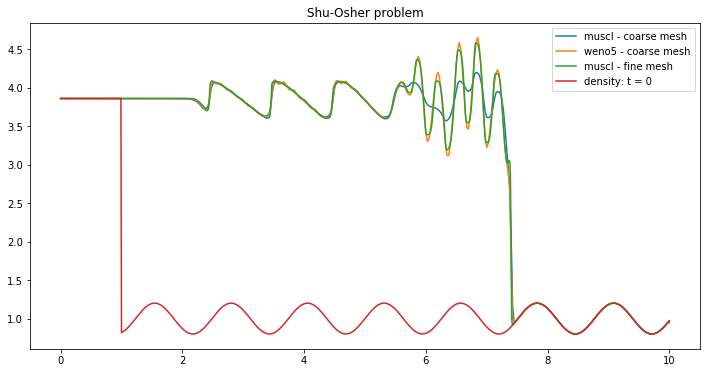

In [22]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x_coarse, P_muscl[0], x_coarse, P_weno5[0], x_fine, P_exact[0], x_fine, Ps_fine.T[0])
plt.legend(['muscl - coarse mesh', 'weno5 - coarse mesh', 'muscl - fine mesh', 'density: t = 0'])
plt.title('Shu-Osher problem')
plt.savefig('Shu-Osher_problem.png')
plt.show()

Trình tự các bước để tạo ra thư viện vncfd_1D được trình bày cụ thể trong khóa học: **[Thực hành CFD với Python! Phần 2: Phương pháp thể tích hữu hạn](https://github.com/SangVn)**.